In [1]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Assignment 3 - Basic Predictions and Regression

## Questions

### Part 1 - Election Prediction

Suppose you are looking at an election in a fictional province. There are 7 total elctoral districts, and the winner in each district is determined by a first-past-the-post system (what we have in Canada - the most votes wins, regardless of share). There are two parties - the Purples and the Yellows. Whoever controls the most seats will be the ruling party - so in our 2 party scenario, the party who wins 4 or more of the districts will govern. There is an election every year, they love voting. 

Recent polling indicating the expected vote share in each district is shown in the "dist_polls" table below. These values are a composite of several polls that the experts have combined and weighted. The "Purple" values show the expected vote share of the Purple party, along with the variance of that expectation and the number of polls that were combined to get that result.  

As well, research has shown that the vote distribution is impacted by voter turnout. In general, the more people vote, the more the vote split shifts towards the Yellow party. We have data on past elections and the results, we expect that the turnout will be in line with the past elections - or more specifically, we have no reason to expect it to differ. This impact is measured in the table in code below - that table shows the voter turnout, in a percentage, as well as the change in the Yellow party's vote share (also in percentage) as compared to the polling averages. For example, if one row showed "52" and ".8", that would mean that voter turnout was 52%, and the Yellow party got .8% higher of a vote share than the polling showed. 

<b>What is the probability that the Purple Party controls the government after the election?</b>

<b>Note:</b> the errors and confidence intervals are not totally trivial. As part of the written answer, offer an evaluation of your confidence in the prediction, and why you think that. This is not a question with one specific error, your estimation will have some expected errors, somewhere. You may not have the tools to calculate it all the way through, that's fine. 

### Question 1 - Your Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li> Build Binomial model
<li> Use Linear regression to predict Yellow improvement with 60% turnout
<li> Calculate the mean for poll per district to predict probability for Purple
<li> Apply the yellow improvement to adjust purple's probability to win
<li> Simulate the probability for 7 districts

<li> <b> What do you think about the error/accuracy:</b>
</ul> The error for each district's prediction is low. The model is accurate enough. But it is confusing that we are using the improvement to predict the vote. I think it is too bias to use for prediction, which will have a high error at beginning. The model cannot get away with that type of error. So the results looks a little odd at the end.

##### Setup Poll Data

The dataframe "dist_polls" contains all of the polls for each seat. Each value is expressed as expected vote share (as a ratio) for the <b>Purple</b> party. The Yellow party can be safely assumed to get the rest of the votes. 

In [2]:
# Please don't edit this part. 
# Setup polling data. 
districts = [1,2,3,4,5,6,7]
dist_polls = pd.DataFrame(districts, columns={"district"})

dist_polls["Poll_1"] = [.55, .49, .51, .6, .41, .46, .54]
dist_polls["Poll_2"] = [.53, .51, .51, .62, .44, .48, .53]
dist_polls["Poll_3"] = [.51, .49, .53, .61, .42, .46, .52]
dist_polls["Poll_4"] = [.47, .48, .51, .54, .45, .45, .51]
dist_polls["Poll_5"] = [.61, .52, .49, .73, .44, .51, .53]
dist_polls["Poll_6"] = [.54, .45, .51, .61, .47, .52, .52]
dist_polls["Poll_7"] = [.55, .47, .5, .56, .47, .46, .56]
dist_polls["Poll_8"] = [.53, .49, .51, .55, .43, .49, .55]
dist_polls["Poll_9"] = [.57, .39, .52, .57, .53, .43, .53]


dist_polls.head()

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53


##### Setup Turnout Data

The dataframe "past_vte_table" shows the voter turnout, along with the impact on the votes counted for the <b>Yellow party</b>, all expressed as percentages. For example, if in one row the turnout is .45 and the Yellow_improvement is -.04, that means that 45% of the populace turned out to vote, and the Yellow party got 4% fewer votes than polling indicated. 

In [3]:
# Please don't edit this part. 
# Setup vote data. 
voter_turnout_history = [.53, .51, .48, .55, .54, .59, .49, .57, .56]
past_vote_table = pd.DataFrame(voter_turnout_history, columns={"voter_turn_percentage"})
past_vote_table["Yellow_improvement"] = [.012, .023, -.017, .031, .030, -.004, -.03, .042, .029]
past_vote_table["year"] = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
past_vote_table.head()

,voter_turn_percentage,Yellow_improvement,year
0,0.53,0.012,2013
1,0.51,0.023,2014
2,0.48,-0.017,2015
3,0.55,0.031,2016
4,0.54,0.030,2017


## Start Your Work

### Part 1 - Election

In [4]:
# Linear regression for Yellow improvement:

x = np.array(past_vote_table["voter_turn_percentage"]).reshape(-1,1)
y = np.array(past_vote_table["Yellow_improvement"]).reshape(-1,1)

model = LinearRegression().fit(x,y)
predictYellow = model.predict(np.array(0.60).reshape(-1,1))

r_sq = model.score(x,y)
print("Coefficient of determination (R_squared):", r_sq)
print("Intercept:", model.intercept_[0])
print("Slop:", model.coef_[0][0])
print("Predict improvement for Yellow:", predictYellow)

Coefficient of determination (R_squared): 0.33225372047195967
Intercept: -0.19374537987679688
Slop: 0.38583162217659167
Predict improvement for Yellow: [[0.03775359]]


<AxesSubplot:xlabel='X', ylabel='Y'>

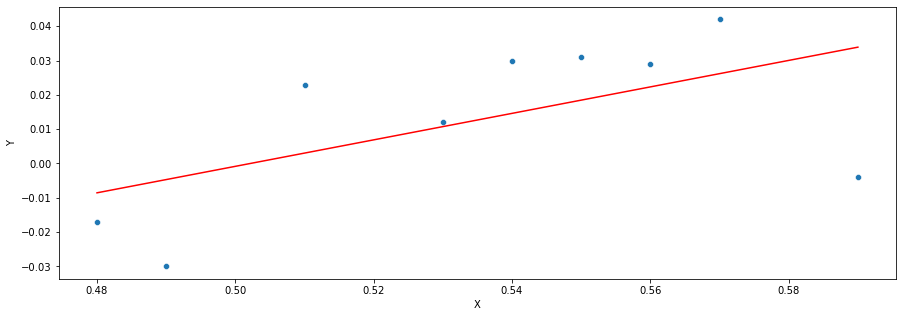

In [5]:
dat = pd.DataFrame(data=np.column_stack((x,y)), columns=["X", "Y"])
sns.scatterplot(data=dat, x="X", y="Y")

inter = model.intercept_[0]
slo = model.coef_[0][0]
inter, slo
lineInf = thinkstats2.FitLine(dat["X"], inter, slo)
sns.lineplot(x=lineInf[0], y=lineInf[1], color="red")

In [6]:
# average of each district with the prediction 

dist_polls["distavg"] = (dist_polls.iloc[:, 1:7].mean(axis = 1)) - (0.03775359)
dist_polls["distavg"] 

0    0.497246
1    0.452246
2    0.472246
3    0.580580
4    0.400580
5    0.442246
6    0.487246
Name: distavg, dtype: float64

In [7]:
dist_polls.head(7)

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9,distavg
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57,0.497246
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39,0.452246
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52,0.472246
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57,0.580580
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53,0.400580
5,6,0.46,0.48,0.46,0.45,0.51,0.52,0.46,0.49,0.43,0.442246
6,7,0.54,0.53,0.52,0.51,0.53,0.52,0.56,0.55,0.53,0.487246


In [8]:
# Generate one vote for Purple
def oneVote(probCalc):
    vote = np.random.binomial(n=1, p=probCalc)
    return vote 


In [9]:
# Generate a lot of vote for Purple
def getSample(voteProb, n=1000):
    vote_list = []
    for i in range(n):
        vote_list.append(oneVote(voteProb))
    return vote_list

In [10]:
# Simulation of Purple:

def getSamples(voteProb, n=1000, samples=100, ciLow=2.5, ciHi=97.5):
    meanList = []
    for i in range(samples):
        meanList.append(np.mean(getSample(voteProb, n)))
    muList = [voteProb] * samples
    cdf = thinkstats2.Cdf(meanList) 
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi) 
    stderr = mean_squared_error(meanList, muList, squared=False)
    return meanList, stderr, cdf, ci

In [28]:
# Calculate the probability of Purple party to win the election:

def simulationP(probP):
    trials = 1000
    means, err, cdfFin, ciFin = getSamples(probP, n=1000, samples=trials) 
    lowest = means - err
    highest = means + err 
    pWins = 0 
    for i in range(len(means)):
        if means[i] > .5000:
            pWins = pWins + 1
    return (pWins/trials), err



In [29]:
dist1 = simulationP(dist_polls["distavg"][0])
dist2 = simulationP(dist_polls["distavg"][1])
dist3 = simulationP(dist_polls["distavg"][2])
dist4 = simulationP(dist_polls["distavg"][3])
dist5 = simulationP(dist_polls["distavg"][4])
dist6 = simulationP(dist_polls["distavg"][5])
dist7 = simulationP(dist_polls["distavg"][6])


In [30]:
print("The fraction for Purple to win in district 1 is:", dist1)
print("The fraction for Purple to win in district 2 is:", dist2)
print("The fraction for Purple to win in district 3 is:", dist3)
print("The fraction for Purple to win in district 4 is:", dist4)
print("The fraction for Purple to win in district 5 is:", dist5)
print("The fraction for Purple to win in district 6 is:", dist6)
print("The fraction for Purple to win in district 7 is:", dist7)

The fraction for Purple to win in district 1 is: (0.408, 0.015965092933901148)
The fraction for Purple to win in district 2 is: (0.001, 0.016145045653329693)
The fraction for Purple to win in district 3 is: (0.03, 0.015709917660131124)
The fraction for Purple to win in district 4 is: (1.0, 0.015637712989837876)
The fraction for Purple to win in district 5 is: (0.0, 0.015358404778683155)
The fraction for Purple to win in district 6 is: (0.0, 0.015872908007296592)
The fraction for Purple to win in district 7 is: (0.192, 0.016025727516967837)


## Conclusion:

### According to the model, Purple will win in District 4, which is 1/7 of the elections. Purple will not win in the next elecion. The error for each district is not high, so we are confident with our model.

### Part 2 - Regression

<b>Use the data provided to try to predict the wage. </b>

The data is from FIFA rankings for players. You don't need to know anything about soccer or video games for this, so if these values are meaningless to you, just treat them as numbers and you'll be fine. All of the features are rankings are evaluations of how good different soccar players are at different skills.

#### Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li> Filter the data before the regression
<li> Use multiple regression to predict
<li> See the RMSE and R2 for accuracy and error
</ul>

In [ ]:
df = pd.read_csv("players_20_2.csv")
df.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
2,290000,87,87,62,87,87,96,88,87,81,...,84,51,36,87,90,90,94,27,26,29
3,125000,13,11,15,43,13,12,13,14,40,...,12,34,19,11,65,11,68,27,12,18
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22


In [ ]:
df.describe()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
count,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,...,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000
mean,9456.942773,49.718405,45.590218,52.221468,58.748003,42.809388,55.596509,47.325692,42.708885,52.768848,...,46.812945,55.742149,46.380239,50.072163,53.609749,48.383357,58.528778,46.848889,47.640333,45.606631
std,21351.714095,18.325403,19.594609,17.428429,14.679653,17.701815,18.929118,18.422991,17.433612,15.246454,...,19.322343,17.318157,20.775812,19.594022,13.955626,15.708099,11.880840,20.091287,21.585641,21.217734
min,0.000000,5.000000,2.000000,5.000000,7.000000,3.000000,4.000000,6.000000,4.000000,8.000000,...,4.000000,9.000000,3.000000,2.000000,9.000000,7.000000,12.000000,1.000000,5.000000,3.000000
25%,1000.000000,38.000000,30.000000,44.000000,54.000000,30.000000,50.000000,34.000000,31.000000,43.000000,...,32.000000,44.000000,25.000000,39.000000,44.000000,39.000000,51.000000,29.000000,27.000000,24.000000
50%,3000.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,49.000000,41.000000,56.000000,...,51.000000,58.000000,52.000000,55.000000,55.000000,49.000000,60.000000,52.000000,55.000000,52.000000
75%,8000.000000,64.000000,62.000000,64.000000,68.000000,56.000000,68.000000,62.000000,56.000000,64.000000,...,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000
max,565000.000000,93.000000,95.000000,93.000000,92.000000,90.000000,97.000000,94.000000,94.000000,92.000000,...,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.000000,94.000000,92.000000,90.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   wage_eur                    18278 non-null  int64
 1   attacking_crossing          18278 non-null  int64
 2   attacking_finishing         18278 non-null  int64
 3   attacking_heading_accuracy  18278 non-null  int64
 4   attacking_short_passing     18278 non-null  int64
 5   attacking_volleys           18278 non-null  int64
 6   skill_dribbling             18278 non-null  int64
 7   skill_curve                 18278 non-null  int64
 8   skill_fk_accuracy           18278 non-null  int64
 9   skill_long_passing          18278 non-null  int64
 10  skill_ball_control          18278 non-null  int64
 11  movement_acceleration       18278 non-null  int64
 12  movement_sprint_speed       18278 non-null  int64
 13  movement_agility            18278 non-null  int64
 14  moveme

In [ ]:
# filter the data:

#df = df[df["wage_eur"]> 10000]
#df = df[df["wage_eur"]< 300000]
#df.sample(10)


In [ ]:
#df.describe()

In [ ]:
# set up data with ScikitLearn:

y = np.array(df["wage_eur"]).reshape(-1, 1)
y.shape

(18278, 1)

In [ ]:
dfN = df.drop(columns = {"wage_eur"})
dfN.head()

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,88,95,70,92,88,97,93,94,92,96,...,94,48,40,94,94,75,96,33,37,26
1,84,94,89,83,87,89,81,76,77,92,...,93,63,29,95,82,85,95,28,32,24
2,87,87,62,87,87,96,88,87,81,95,...,84,51,36,87,90,90,94,27,26,29
3,13,11,15,43,13,12,13,14,40,30,...,12,34,19,11,65,11,68,27,12,18
4,81,84,61,89,83,95,83,79,83,94,...,80,54,41,87,89,88,91,34,27,22


In [ ]:
x = np.array(dfN)
x.shape

(18278, 29)

In [ ]:
# Split data:

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

print(xTrain.shape, yTrain.shape)
print(xTest.shape, yTest.shape)

(12794, 29) (12794, 1)
(5484, 29) (5484, 1)


In [ ]:
# Generate model:

model = LinearRegression().fit(xTrain, yTrain)

r_sq = model.score(xTest, yTest)
print("R-squared:", r_sq)

R-squared: 0.2824317054166351


In [ ]:
# Coeffcient:

print("Intercept:", model.intercept_[0])
print("Coefs:", model.coef_[0])

Intercept: -67325.24110754009
Coefs: [ 1.36385945e+01  1.18027014e+01 -3.35730987e-01  8.00089114e+01
  1.12761732e+02  1.11668188e+01  4.32425340e+01 -4.14910445e+01
  1.64476152e+01  9.80912807e+01  4.49582004e+01  4.90675479e+01
 -1.02944166e+02  9.14083735e+02 -3.93928471e+01  1.27825939e+02
  5.65728784e+01 -1.02392997e+02 -1.98664913e+01 -1.94508332e+02
 -6.06638739e+01 -2.17591126e+01 -9.47635262e+01  1.26665602e+02
 -1.91806168e+01  2.21892810e+02 -3.44995143e+01  1.02991348e+02
 -4.88149007e+01]


In [ ]:
# RMSE and Residules:

tmp = model.predict(xTest)
RMSE = mean_squared_error(tmp, yTest, squared = False)
print("RMSE:", RMSE)

RMSE: 18124.50455153029


In [ ]:
tmp1 = pd.DataFrame(yTest, columns = {"Y values"})
tmp2 = pd.DataFrame(tmp, columns = {"Predictions"})
tmp3 = pd.DataFrame((yTest-tmp), columns = {"Residule"})
resFrame = pd.concat([tmp1, tmp2, tmp3], axis = 1)
resFrame.head()

,Y values,Predictions,Residule
0,1000,-18489.986037,19489.986037
1,4000,1945.482109,2054.517891
2,8000,20726.501434,-12726.501434
3,2000,10946.513016,-8946.513016
4,3000,16004.381841,-13004.381841


The RMSE is 18124.50455153029

R square is 0.2824317054166351

In [ ]:
# Fit the model with Statsmodels:

import statsmodels.api as sm

x2 = sm.add_constant(xTrain)
est = sm.OLS(yTrain, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     172.6
Date:                Fri, 25 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:36:25   Log-Likelihood:            -1.4357e+05
No. Observations:               12794   AIC:                         2.872e+05
Df Residuals:                   12764   BIC:                         2.874e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.733e+04   1935.499    -34.784      0.0

In [ ]:
# RMSE:
ypred = est2.predict(sm.add_constant(xTest))
rmse2 = mean_squared_error(yTest, ypred, squared=False)
print("RMSE:", rmse2)

RMSE: 18124.50455153029


The RMSE is 18124.50455153029

The R squre is 0.282

Our R squre is 28.2%, which is low. The RMSE is super high too. Our model is not good to predict the wage_eur with the data we have. 

I did not remove the outliers, because the RMSE  and R_square get higher after I remove them. It could be the elements we are using, which are not good for predicting the wage. 
